# This model here is trained on weather data to see if by knowing the weather of previous hour it is reasonable to predict the future solar intensity

## Loading data and converting to dataframe

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import datetime
import sklearn

### Solar intensity data

In [4]:
#Load initial data
hourly_sun_intensity = pd.read_excel('./data/2-10_21_524-2 Andmed.xlsx', sheet_name = 'tunni sum.kiirgus', header = 1)

In [5]:
#Update column names by shortening them and converting to English
newColumnNames = dict()
newColumnNames["Aasta"] = "y"
newColumnNames["Kuu"] = "m"
newColumnNames["Päaev"] = "d"
newColumnNames["Kell (UTC)"] = "time"
for columnName in hourly_sun_intensity.columns:
    if "kiirgus" in columnName:
        newColumnNames[columnName] = "solar_"+columnName.replace(" summaarne kiirgus, W/m²", "")
hourly_sun_intensity = hourly_sun_intensity.rename(columns=newColumnNames)


In [6]:
# Some weather stations have changed locations over time, as the differences between their locations are rather small (less than 8 km)
# We at first do not make separation between them

def join_columns(c1, c2, nc, df, column_id): # Function for joining columns, where an area has two weather measuring points
    data = []
    cs = [c1, c2]
    for i, rows in df[cs].iterrows():
        if (pd.isna(rows[0]) == True) & (pd.isna(rows[1]) == False):
            data.append(round(rows[1], 2))
        elif (pd.isna(rows[0]) == False) & (pd.isna(rows[1]) == True):
            data.append(round(rows[0], 2))
        elif (pd.isna(rows[0]) == False) & (pd.isna(rows[1]) == False):
            data.append(round(rows.mean(), 2))
        elif (pd.isna(rows[0]) == True) & (pd.isna(rows[1]) == True):
            data.append(rows[0])

    df = df.drop(columns = [c1, c2])
    df.insert(column_id, nc, data)
    
    return df

In [7]:
#Merge columns, which are due to weather station moving
hourly_sun_intensity = join_columns('solar_Narva', 'solar_Narva-Jõesuu', 'solar_Narva', hourly_sun_intensity, 4)
hourly_sun_intensity = join_columns('solar_Pärnu-Sauga', 'solar_Pärnu', 'solar_Pärnu', hourly_sun_intensity, 5)

In [8]:
#Drop rows where some value is missing
hourly_sun_intensity = hourly_sun_intensity.dropna()
#If value is -1 it corresponds to night, set it to 0
hourly_sun_intensity = hourly_sun_intensity.replace(-1, 0)

In [9]:
#Shift the times -X minutes to facilitate predicting future solar intensity from existing
def shiftDateTime(df, numberOfHours):
    dateTimes = []
    for i in range(len(df)):
        row = df.iloc[i]
        dateTimes+=[datetime.datetime.combine(datetime.date(row.y, row.m, row.d), row.time)+datetime.timedelta(hours=numberOfHours)]
    df2 = copy.deepcopy(df)
    df2["y"] = [date.year for date in dateTimes]
    df2["m"] = [date.month for date in dateTimes]
    df2["d"] = [date.day for date in dateTimes]
    df2["time"] = [date.time() for date in dateTimes]
    
    return df2
    
    

In [10]:
hourly_sun_intensity_Shifted = shiftDateTime(hourly_sun_intensity, -1)

### Data from different weather stations

#### Locations


Tallinn-Harku
Laius: N 59°23´53´´
Pikkus: E 24°36´10´´
Decimal
Lat: 59.398055
Long: 24.602778


Haapsalu meteoroloogiajaam
Laius N 58°56´40´´
Pikkus E 23°33´18´´
Decimal
Lat: 58.944444
Long: 23.555

Narva
Laius: N 59°23´22´´
Pikkus: E 28°06´33´´
Decimal
Lat: 59.389444
Long: 28.109167

Pärnu
Laius: N 58°23´4,44´´
Pikkus: E 24°29´6,71´´
Decimal
Lat: 58.384556
Long: 24.485197

Roomassaare
Laius: N 58°13’05”
Pikkus: E 22°30’23”
Decimal
Lat: 58.218056 
Long: 22.506389 

Tartu-Tõravere meteoroloogiajaam
Laius: N 58°15´51´´
Pikkus: E 26°27´41´
Decimal
Lat: 58.264167
Long: 26.461389

Tiirikoja järvejaam
Laius: N 58°51´55´´
Pikkus: E 26°57´08´´
Decimal
Lat: 58.865278
Long: 26.952222

Vilsandi rannikujaam
Laius: N 58°22´58”
Pikkus: E 21°48´51”
Deciaml
Lat: 58.382778
Long: 21.814167

In [11]:
selectedColumns = ["Aasta", "Kuu", "Päev", "Kell (UTC)", 
                   "Õhutemperatuur °C","Suhteline õhuniiskus %",
                   "Õhurõhk jaama kõrgusel hPa",
                   "10 minuti keskmine tuule kiirus m/s", 
                   "10 minuti keskmine tuule suund"]

In [12]:
#Update column names by shortening them and converting to English

def updateColumnNames(df, location):
    newColumnNames = dict()
    newColumnNames["Aasta"] = "y"
    newColumnNames["Kuu"] = "m"
    newColumnNames["Päev"] = "d"
    newColumnNames["Kell (UTC)"] = "time"
    newColumnNames["Õhutemperatuur °C"] = f"temp_{location}"
    newColumnNames["10 minuti keskmine tuule kiirus m/s"] = f"wind_speed_{location}"
    newColumnNames["Õhurõhk jaama kõrgusel hPa"] = f"pressure_{location}"
    newColumnNames["Suhteline õhuniiskus %"] = f"rel_humidity_{location}"
    newColumnNames["10 minuti keskmine tuule suund"] = f"wind_dir_{location}"
    df = df.rename(columns=newColumnNames)
    return df

In [13]:
def getFromXlsx(filename, columns, location):
    #Load xlsx
    df = pd.read_excel(filename, header = 1)
    df = df[columns]
    #Drop rows where data is missing
    #df = df.dropna()
    #Update column names for clarity
    df = updateColumnNames(df, location)
    return df

In [14]:
#Get Tallinn
data_tallinn = getFromXlsx("./data/Tallinn-Harku_2004-2020.xlsx", selectedColumns, 'Tallinn-Harku')
#Get Roomassaare
data_roomassaare = getFromXlsx("./data/Roomassaare_2008-2020.xlsx", selectedColumns, 'Roomassaare')
#Merge tables
data_weather = data_tallinn.merge(data_roomassaare, how='left', on=["y", "m", "d", "time"])

In [15]:
#Get Vilsandi
data_vilsandi = getFromXlsx("./data/Vilsandi_2004-2020.xlsx", selectedColumns, "Vilsandi")
#Merge tables
data_weather = data_weather.merge(data_vilsandi, how='left', on=["y", "m", "d", "time"])

In [16]:
#Get Tartu
data_Tartu = getFromXlsx("./data/Tartu-Toravere_2004-2020.xlsx", selectedColumns, 'Tartu-Tõravere')
#Merge tables
data_weather = data_weather.merge(data_Tartu, how='left', on=["y", "m", "d", "time"])

In [17]:
#Get Tiirikoja
data_Tiirikoja = getFromXlsx("./data/Tiirikoja_2004-2020.xlsx", selectedColumns, "Tiirikoja")
data_weather = data_weather.merge(data_Tiirikoja, how='left', on=["y", "m", "d", "time"])

In [18]:
#Get Narva
data_Narva = getFromXlsx("./data/Narva_19.12.2013-2020.xlsx", selectedColumns, "Narva")
data_weather = data_weather.merge(data_Narva, how='left', on=["y", "m", "d", "time"])

In [19]:
#Once again drop all rows where some row is missing
data_weather = data_weather.dropna()

### Join weather and solar data

In [20]:
data_solar_weather = hourly_sun_intensity_Shifted.merge(data_weather, how='left', on=["y", "m", "d", "time"])

In [21]:
hours = []
for i in range(len(data_solar_weather)):
    hours+=[data_solar_weather.iloc[i].time.hour]
data_solar_weather["h"] = hours


In [22]:
data_solar_weather = data_solar_weather.dropna()

## Create dataframe where the location is not important

In [23]:
weatherStations = ['Tallinn-Harku', 'Roomassaare', "Vilsandi", 'Tartu-Tõravere', "Tiirikoja", "Narva"]

In [24]:
data_solar_weather_noLocation = pd.DataFrame()

for weatherStation in weatherStations:
    #Select right columns
    data_solar_weather_location = data_solar_weather[['y', 'm', 'd', 'h', f'temp_{weatherStation}', f'wind_speed_{weatherStation}',
       f'pressure_{weatherStation}', f'rel_humidity_{weatherStation}', f'solar_{weatherStation}']]
    columnNames = dict()
    for i in range(len(data_solar_weather_location.columns)):
        columnNames[data_solar_weather_location.columns[i]] = data_solar_weather_location.columns[i].replace(f"_{weatherStation}", "")
    data_solar_weather_location = data_solar_weather_location.rename(columns=columnNames)
    
    data_solar_weather_noLocation = data_solar_weather_noLocation.append(data_solar_weather_location)

In [25]:
data_solar_weather_noLocation = data_solar_weather_noLocation.dropna()

# Let's train models

### Data Prep

In [26]:
data_solar_weather_noLocation.columns

Index(['y', 'm', 'd', 'h', 'temp', 'wind_speed', 'pressure', 'rel_humidity',
       'solar'],
      dtype='object')

In [27]:
X = data_solar_weather_noLocation[['m','d', 'h', 'temp',
       'rel_humidity', 'wind_speed']]

y = data_solar_weather_noLocation[['solar']].values.ravel()

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=111)

In [29]:
#from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
scaler = PCA(n_components=0.9)
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Random Forest

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [29]:
results_df = pd.DataFrame()

In [30]:
rf= RandomForestRegressor()
rf.fit(X_train_scaled, y_train)
mean_squared_error(y_test, rf.predict(X_test_scaled), squared = False)

68.57019755155672

In [31]:
############### Random Forest ##############################

n_estimatorss = [100, 150]
max_depths=[10,20, 30]
min_samples_splits=[4,6,8,16]
seeds = [1]
results_df = pd.DataFrame(columns=['model',"seed","n_estimators","max_depth","min_samples_split",'TrainError', 'ValError', 'deltaErrors'])
for seed in seeds:
    for n_estimator in n_estimatorss:
        for max_d in max_depths:
            for min_ss in min_samples_splits:
                rf = RandomForestRegressor(criterion="squared_error", n_estimators=n_estimator, max_depth=max_d, min_samples_split=min_ss, random_state=seed).fit(X_train_scaled, y_train)
                trainError = mean_squared_error(y_train, rf.predict(X_train_scaled), squared = False)
                valError = mean_squared_error(y_test, rf.predict(X_test_scaled), squared = False)
                results_df = results_df.append({'model': 'RF',"seed":seed,"n_estimators":n_estimator,"max_depth":max_d,"min_samples_split":min_ss,"TrainError":trainError, 'ValError':valError, 'deltaErrors':abs(trainError-valError)}, ignore_index=True)

In [32]:
results_df.sort_values("ValError")

,model,seed,n_estimators,max_depth,min_samples_split,TrainError,ValError,deltaErrors
21,RF,1,150,30,6,35.705530,68.434446,32.728917
20,RF,1,150,30,4,30.489803,68.455105,37.965302
22,RF,1,150,30,8,40.016509,68.513734,28.497225
9,RF,1,100,30,6,35.831657,68.584764,32.753106
8,RF,1,100,30,4,30.642890,68.599377,37.956487
10,RF,1,100,30,8,40.112195,68.643792,28.531597
17,RF,1,150,20,6,43.068779,68.811104,25.742325
16,RF,1,150,20,4,40.158060,68.822318,28.664258
18,RF,1,150,20,8,45.721205,68.855232,23.134026
23,RF,1,150,30,16,50.362083,68.881218,18.519135


### Gradient Boosting

In [33]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor


############### HistGradientBoostingRegressor ##############################

learning_rates = [0.3, 0.2, 0.1, 0.05, 0.01]
l2_regularizations=[0, 0.1, 0.2]
results_gb_df = pd.DataFrame(columns=['model',"lr","l2",'TrainError', 'ValError', 'deltaErrors'])
for learning_rate in learning_rates:
    for l2_regularization in l2_regularizations:
        gb = HistGradientBoostingRegressor(l2_regularization=l2_regularization, learning_rate=learning_rate).fit(X_train_scaled, y_train)
        trainError = mean_squared_error(y_train, gb.predict(X_train_scaled), squared = False)
        valError = mean_squared_error(y_test, gb.predict(X_test_scaled), squared = False)
        results_gb_df = results_gb_df.append({'model': 'GB', "lr":learning_rate , "l2":l2_regularization, "TrainError":trainError, 'ValError':valError, 'deltaErrors':abs(trainError-valError)}, ignore_index=True)

/home/main/anaconda3/envs/metsat/lib/python3.7/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


In [34]:
results_gb_df.sort_values("ValError")

,model,lr,l2,TrainError,ValError,deltaErrors
1,GB,0.30,0.1,66.838694,70.185922,3.347228
2,GB,0.30,0.2,66.640537,70.371888,3.731351
0,GB,0.30,0,66.741161,70.398770,3.657609
5,GB,0.20,0.2,68.415612,70.507490,2.091878
3,GB,0.20,0,68.305342,70.507883,2.202541
4,GB,0.20,0.1,68.188231,70.665712,2.477481
7,GB,0.10,0.1,70.853276,71.838496,0.985220
6,GB,0.10,0,70.917794,71.910700,0.992906
8,GB,0.10,0.2,70.916022,71.940059,1.024037
10,GB,0.05,0.1,73.467473,73.691990,0.224517


## SVR

In [35]:
#from sklearn import svm

#clf = svm.SVR()
#clf.fit(X_train, y_train)
#mean_squared_error(y_test.values, clf.predict(X_test), squared = False)

## KNN

In [36]:
from sklearn.neighbors import KNeighborsRegressor

############### KNNRegressor ##############################

neighbors = [5,7,9,11,13,17,21]

results_knn_df = pd.DataFrame(columns=['model',"neighbors",'TrainError', 'ValError', 'deltaErrors'])

for neighbor in neighbors:
    knn = KNeighborsRegressor(n_neighbors=neighbor).fit(X_train_scaled, y_train)
    trainError = mean_squared_error(y_train, knn.predict(X_train_scaled), squared = False)
    valError = mean_squared_error(y_test, knn.predict(X_test_scaled), squared = False)
    results_knn_df = results_knn_df.append({'model': 'KNN', "neighbors":neighbor, "TrainError":trainError, 'ValError':valError, 'deltaErrors':abs(trainError-valError)}, ignore_index=True)


In [37]:
results_knn_df.sort_values("ValError")

,model,neighbors,TrainError,ValError,deltaErrors
2,KNN,9,62.533452,69.614360,7.080908
3,KNN,11,63.986349,69.697850,5.711502
1,KNN,7,60.362466,69.783996,9.421530
4,KNN,13,65.109113,69.918947,4.809834
0,KNN,5,57.081651,69.998442,12.916792
5,KNN,17,66.657459,70.346076,3.688617
6,KNN,21,67.803563,70.633675,2.830112


## Decision Tree

In [53]:
from sklearn.tree import DecisionTreeRegressor

############### DT_Regressor ##############################

max_depths=[5, 10, 20, 30]
min_samples_splits=[4,6,8,16]
seeds = [1]
results_dt_df = pd.DataFrame(columns=['model',"seed","max_depth","min_samples_split",'TrainError', 'ValError', 'deltaErrors'])

for seed in seeds:
    for max_d in max_depths:
        for min_ss in min_samples_splits:
            dt = DecisionTreeRegressor(max_depth=max_d, min_samples_split=min_ss, random_state=seed).fit(X_train_scaled, y_train)
            trainError = mean_squared_error(y_train, dt.predict(X_train_scaled), squared = False)
            valError = mean_squared_error(y_test, dt.predict(X_test_scaled), squared = False)
            results_dt_df = results_dt_df.append({'model': 'DT',"seed":seed,"max_depth":max_d,"min_samples_split":min_ss,"TrainError":trainError, 'ValError':valError, 'deltaErrors':abs(trainError-valError)}, ignore_index=True)


In [54]:
results_dt_df.sort_values("ValError")

,model,seed,max_depth,min_samples_split,TrainError,ValError,deltaErrors
7,DT,1,10,16,78.477642,79.308696,0.831054
6,DT,1,10,8,78.455128,79.310792,0.855665
5,DT,1,10,6,78.454828,79.312137,0.857309
4,DT,1,10,4,78.443469,79.321116,0.877648
11,DT,1,20,16,55.254497,80.927895,25.673398
15,DT,1,30,16,50.590134,82.764992,32.174858
10,DT,1,20,8,48.463069,84.405186,35.942117
9,DT,1,20,6,45.828697,85.733437,39.904740
8,DT,1,20,4,42.719913,87.274605,44.554692
14,DT,1,30,8,37.745354,88.378190,50.632837


In [55]:
bestResults = dict()
bestResults["DT"] = results_dt_df.sort_values(by="ValError").iloc[0]
bestResults["RF"] = results_df.sort_values(by="ValError").iloc[0]
bestResults["GB"] = results_gb_df.sort_values(by="ValError").iloc[0]
bestResults["KNN"] = results_knn_df.sort_values(by="ValError").iloc[0]

DT
79.30869614467379
RF
68.4344464052223
GB
70.18592155605361
KNN
69.61436039211355


Text(0, 0.5, 'RMSE [W/m$^{2}$]')

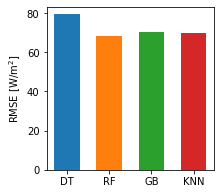

In [65]:
results = [(bestResults[key]["ValError"]) for key in bestResults.keys()]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))
for i in range(len(bestResults.keys())):
    ax.bar(list(bestResults.keys())[i] ,results[i], width=0.6)
    print(list(bestResults.keys())[i])
    print(results[i])
    #ax.bar(list(bestResults.keys()) ,results, width=0.6)
ax.set_ylabel(r"RMSE [W/m$^{2}$]")

In [ ]:
np.arg(results_df.ValError.values)